# Keyword Extraction

This notebook shows various keyword extraction to extract the key phrases and words in the reviews. Various methods are considered, including extracting noun phrases and keywords for each category.

* Section 1 - Import libraries and dataset
* Section 2 - Cleaning
* Section 3 - Noun phrase extraction
* Section 4 - TextRank
* Section 5 - Keyword extraction - unigrams
* Section 6 - Bigrams
* Section 7 - Summary

Dataset needed to run notebook:

* explodedsentencecleaned.csv

Data saved to:

* noun_phrase_exploded.csv

# Import Libraries and Dataset

In [1]:
#!pip install pyLDAvis
!pip install contractions

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import contractions
import string
import re
from textblob import TextBlob
import nltk
nltk.download('stopwords')
nltk.download('brown')
nltk.download('wordnet')
from nltk.util import ngrams
from nltk.tokenize import RegexpTokenizer, word_tokenize,sent_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import sent_tokenize
from spellchecker import SpellChecker
import gensim
from gensim.utils import simple_preprocess
from gensim import corpora, models
from gensim.models import TfidfModel
from gensim.summarization import keywords
from operator import itemgetter
from collections import Counter
import ast
import warnings
warnings.filterwarnings("ignore")

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\imoge\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package brown to
[nltk_data]     C:\Users\imoge\AppData\Roaming\nltk_data...
[nltk_data]   Package brown is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\imoge\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


# Section2: Cleaning and pre-processing

In [3]:
# Read back in PRE-PROCESSED FILE
df = pd.read_csv("explodedsentencescleaned.csv",index_col = 0)
df.columns = ["OrigInd","Category","Town","Rating","all_text","sentences","len","cleaned_sentences"]
df.head()

,OrigInd,Category,Town,Rating,all_text,sentences,len,cleaned_sentences
0,0,Accommodation,Bognor,4,"Nice break, shame about the accommodation... W...","Nice break, shame about the accommodation... W...",173,nice break shame accommodation booked night st...
0,0,Accommodation,Bognor,4,"Nice break, shame about the accommodation... W...",We’d never been to Butlins before so weren’t r...,283,would never not really sure expect review eith...
0,0,Accommodation,Bognor,4,"Nice break, shame about the accommodation... W...",First impressions weren’t good –we arrived and...,159,first impression not good we arrived parked ca...
0,0,Accommodation,Bognor,4,"Nice break, shame about the accommodation... W...",Bearing in mind that people in the apartments ...,289,bearing mind people apartment obviously self-c...
0,0,Accommodation,Bognor,4,"Nice break, shame about the accommodation... W...","So, we had to do 2 trips back and forth from o...",182,trip back forth one side resort balancing stuf...


In [4]:
df["cleaned_sentences"].iloc[0]

'nice break shame accommodation booked night stay december post-christmas treat family adult kid 5.5 year old'

In [5]:
df.shape

(59956, 8)

In [6]:
#df["Score"] = df["Rating"]
#df = df[df["Rating"] != 3]
#df.Score.replace([1,2], 1, inplace = True)
#df.Score.replace([4,5], 0, inplace = True)
#df.drop(columns = ["Rating"],axis = 1, inplace = True)

# Section 3: Noun Phrase Extraction - unweighted and weighted

A noun phrase is a small group of words which contains a noun

Using the full dataset not split into sentences.


## Unweighted

In [6]:
# Create function to extract noun phrases from a review using TextBlob
def noun_finder(x):
    blob = TextBlob(x)
    return blob.noun_phrases

In [7]:
# Sample review
example = df["cleaned_sentences"].iloc[2]
example

'first impression not good we arrived parked car park discover apartment furthest distance away accommodation'

In [8]:
example_noun_phrases = noun_finder(example)
example_noun_phrases

WordList(['car park', 'apartment furthest distance'])

In [9]:
# Put to a normal python list 
new_list = []
for item in example_noun_phrases:
    new_list.append(item)
new_list

['car park', 'apartment furthest distance']

In [10]:
# Make sure sentences are strings and then apply the function to whole dataframe
df["cleaned_sentences"] = df["cleaned_sentences"].astype(str)
df["noun_phrases"] = df["cleaned_sentences"].apply(lambda x: noun_finder(x))

In [11]:
df.head(2)

,OrigInd,Category,Town,Rating,all_text,sentences,len,cleaned_sentences,noun_phrases
0,0,Accommodation,Bognor,4,"Nice break, shame about the accommodation... W...","Nice break, shame about the accommodation... W...",173,nice break shame accommodation booked night st...,"[shame accommodation, night stay december post..."
0,0,Accommodation,Bognor,4,"Nice break, shame about the accommodation... W...",We’d never been to Butlins before so weren’t r...,283,would never not really sure expect review eith...,"[good terrible, usual choice]"


In [12]:
# Remove any empty lists
df = df[(df['noun_phrases'].str.len() != 0)]
df.shape

(45734, 9)

In [13]:
# Look at an example
df["noun_phrases"].iloc[10]

WordList(['basic thing', 'resort day'])

In [20]:
# Compare to original review sentence
df["sentences"].iloc[10]

'No towels were provided (although we already knew this, but it’s still a basic thing that’s provided in most resorts these days).'

In [15]:
# Split between the categories - accommodation, food and attractions
h = df[df["Category"] == "Accommodation"]
f = df[df["Category"] == "Food"]
a = df[df["Category"] == "Attractions"]

Extracting noun phrases for each review does appear to identify helpful information at a detail level.

In [16]:
# Function to extract the noun phrases into list of lists
def noun_extract(df):
    words = df["noun_phrases"].apply(lambda x: [item for item in x]).tolist()
    return words

In [17]:
# Apply to dataframes
words_accom = noun_extract(h)
words_food = noun_extract(f)
words_attract = noun_extract(a)

In [19]:
# Look at an example
words_accom[20]

['seat table', 'queue min door']

## Weighted

In [21]:
# Create the gensim dictionary and corpus and get the weighted noun phrases bassed on the TFIDF model (for whole dataframe)
# Code source: Text Analytics with Python (Sarkar)

def createdictionary(df):
    dictionary  = corpora.Dictionary(df)
    corpus = [dictionary.doc2bow(word) for word in df]
    model = TfidfModel(corpus) 
    vector = model[corpus]
    weighted_noun_phrases = {dictionary.get(idx): value for doc in vector for idx, value in doc}
    weighted_noun_phrases_s = sorted(weighted_noun_phrases.items(),key = itemgetter(1),reverse = True)
    weighted_noun_phrases_s = [(term,round(wt,3)) for term,wt in weighted_noun_phrases_s]
    
    return weighted_noun_phrases, weighted_noun_phrases_s

In [22]:
# Run function against the noun phrases word list
weighted_noun_accom = createdictionary(words_accom)[1]
weighted_noun_food = createdictionary(words_food)[1]
weighted_noun_attract = createdictionary(words_attract)[1]

In [23]:
# Get the top 10 weighted noun phrases for accomodation
weighted_noun_accom[:10]

[('usual choice', 1.0),
 ('basic apartment', 1.0),
 ('tobacco smoke kid room', 1.0),
 ('resort day', 1.0),
 ('wife decision', 1.0),
 ('basic usual thing need plate cup cutlery tea coffee toaster', 1.0),
 ('yes building', 1.0),
 ('apartment place', 1.0),
 ('absolute highlight weekend', 1.0),
 ('busy wave pool', 1.0)]

In [24]:
# Get the top 10 weighted noun phrases for food
weighted_noun_food[:10]

[('salad steak frites homemade pie', 1.0),
 ('aubergine curry delicious', 1.0),
 ('decent lunch', 1.0),
 ('staff attentive', 1.0),
 ('location river pleasant', 1.0),
 ('lovely staff', 1.0),
 ('worth visit', 1.0),
 ('dinner eaten', 1.0),
 ('quiet couple table', 1.0),
 ('dish member group', 1.0)]

In [25]:
# Get the top 10 weighted noun phrases for attractions
weighted_noun_attract[:10]

[('beautiful garden winter', 1.0),
 ('beautiful garden walk', 1.0),
 ('cafe ground wonder behold', 1.0),
 ('marvellous garden', 1.0),
 ('latte froth taste', 1.0),
 ('americana dish water', 1.0),
 ('cake stale', 1.0),
 ('worth visit', 1.0),
 ('dominates skyline', 1.0),
 ('part building', 1.0)]

This does highlight noun phrases but is perhaps too specific, a more general summary is more helpful when considering a large number of reviews.

# Section 4: Keywords in Gensim using TextRank

Useful to find most relevant sentences or keywords in text. Graph based model so two words found together given higher weight

Source: https://web.eecs.umich.edu/~mihalcea/papers/mihalcea.emnlp04.pdf

In [26]:
# Function to join list of lists to list of strings then join to get a string. Textrank is a graph-based ranking model
    
def join_words(df):
    words_joined = [','.join(word) for word in df] 
    words_joined = ' '.join(words_joined)
    key_words = keywords(words_joined,ratio = 1.0, scores = True, lemmatize = True)
    [(item,round(score,3)) for item,score in key_words[:15]]
    return key_words

In [27]:
# Run function against the noun phrases dataframe
key_words_accom = join_words(words_accom)
key_words_food = join_words(words_food)
key_words_attract = join_words(words_attract)

In [31]:
# First 10 key words - weighted
key_words_accom[0:15]

[('rooms', 0.28452962374641216),
 ('hotels', 0.19587295312710828),
 ('great', 0.168932098000206),
 ('nights', 0.14969637411709785),
 ('breakfast', 0.12743138012258634),
 ('restaurants', 0.11497922983221022),
 ('nice', 0.10715854746578576),
 ('families', 0.10387669074832792),
 ('poole', 0.10140055538106281),
 ('bits', 0.10045778905338532),
 ('kids', 0.09863448157460544),
 ('needs', 0.098339198838506),
 ('weekenders', 0.09572227410410056),
 ('helpfulness', 0.08911276683485878),
 ('small', 0.08220319819597384)]

In [32]:
key_words_food[0:15]

[('goodness', 0.22572711796121223),
 ('greatful', 0.1925163211708813),
 ('restaurants', 0.16155298262017853),
 ('places', 0.13576044680616864),
 ('service fantastic', 0.12659582916436066),
 ('food menu bit mish', 0.12345743817385607),
 ('lovely birthday', 0.11089713555794911),
 ('pub', 0.10593546070109845),
 ('deliciousness', 0.10534266824742261),
 ('visiting', 0.1028061921091894),
 ('excelent', 0.10152445608420622),
 ('friendliness', 0.10020314756933701),
 ('chips', 0.09394037821214161),
 ('drinks', 0.0931793189561707),
 ('friends', 0.08880857592849987)]

In [33]:
key_words_attract[0:15]

[('visit', 0.19593521573414013),
 ('places', 0.16506520928960625),
 ('park', 0.14161468934890112),
 ('gorgeous great', 0.1377175528415157),
 ('staff', 0.1316991665074741),
 ('walk', 0.1270435017550803),
 ('goodness reception', 0.11889518080788569),
 ('child', 0.11059348109620476),
 ('nice', 0.10574411634387558),
 ('cafe ground', 0.09070804229002584),
 ('prices', 0.08729077372760435),
 ('birds', 0.08723562124975229),
 ('small', 0.08567485791581897),
 ('birthday age lovely', 0.0835118799516613),
 ('people', 0.0819489389619156)]

* Service, food and staff are the main themes for food outlets, for accommodation and attractions it is less clearcut
* Many of the words are very specific rather than being general aspects

# Section 5: Extracting Nouns - Unigrams

In [34]:
# Tokenize and get parts of speech function then extract nouns only (convert string to a list first with literal eval)

def token(df):
    import ast
    df['pos'] = df["cleaned_sentences"].apply(lambda x:nltk.tag.pos_tag(x.split()))
    df['nouns'] = df['pos'].apply(lambda x: [i[0] for i in x if i[1].startswith('N')])
    df["nouns_count"] = df["nouns"].apply(lambda x: Counter(x))
    return df

In [35]:
# Run function for each of the categories
nouns_accom = token(h)
nouns_food = token(f)
nouns_attract = token(a)

In [36]:
# Function to get the top words across all the reviews for each category
def count_total(df,col):
    df = df[col].sum().most_common()
    return df

In [37]:
# Example review
print(nouns_accom["nouns_count"].iloc[0])

Counter({'break': 1, 'accommodation': 1, 'night': 1, 'stay': 1, 'treat': 1, 'family': 1, 'adult': 1, 'kid': 1, 'year': 1})


In [38]:
# Run function for all dataframes
accom_count = pd.DataFrame(count_total(nouns_accom,"nouns_count"),columns = ["Word","Count"])
food_count = pd.DataFrame(count_total(nouns_food,"nouns_count"),columns = ["Word","Count"])
attract_count = pd.DataFrame(count_total(nouns_attract,"nouns_count"),columns = ["Word","Count"])

In [39]:
# List accommodation top 15 words
accom_count.head(15)

,Word,Count
0,room,2488
1,staff,1630
2,hotel,1557
3,food,1040
4,night,887
5,breakfast,791
6,pool,693
7,stay,691
8,family,600
9,place,582


In [40]:
def graphmatplot(df,name):
    fig, ax = plt.subplots(figsize = (8,6))
    ax.set_facecolor("White")
    df = df.sort_values(by = "Count",ascending = False).head(15)
    ax.barh(df["Word"], width = df["Count"], color = "lightsteelblue")
    ax.set_title(name,fontsize = 14)
    ax.invert_yaxis()
    ax.set_xlabel("Number of Occurrences",labelpad = 10)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    plt.show()

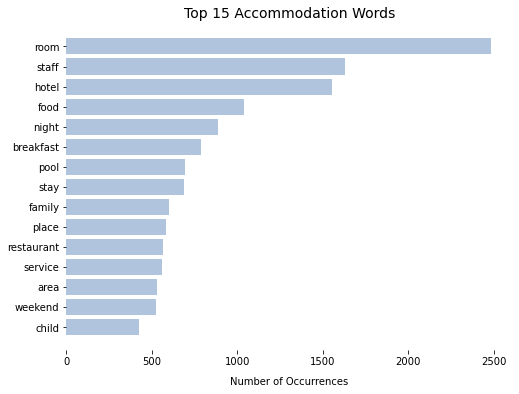

In [41]:
graphmatplot(accom_count,"Top 15 Accommodation Words")

In [42]:
# Top 15 nouns associated with food and the frequencies
food_count.head(15)

,Word,Count
0,food,5763
1,service,2895
2,staff,2804
3,meal,1713
4,restaurant,1600
5,lunch,1437
6,place,1371
7,menu,1169
8,visit,891
9,chip,829


In [43]:
# Remove odd words
food_count = food_count[food_count["Word"] != "chip"]

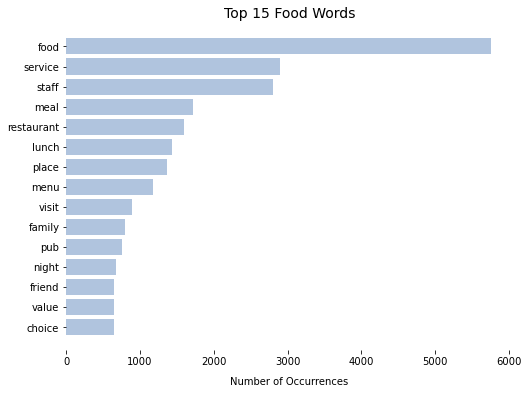

In [44]:
graphmatplot(food_count,"Top 15 Food Words")

In [45]:
# Top 15 nouns associated with attractions and the frequencies
attract_count.head(15)

,Word,Count
0,visit,377
1,garden,362
2,place,313
3,staff,256
4,park,241
5,area,218
6,beach,202
7,walk,190
8,room,177
9,family,160


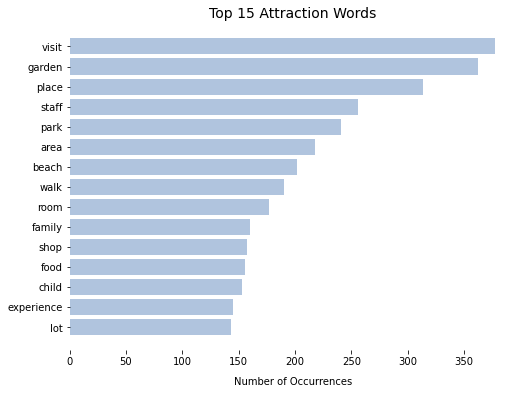

In [46]:
graphmatplot(attract_count,"Top 15 Attraction Words")

* Using just nouns gives a good idea of the important themes based on frequency of noun occurrence 
* Certain words like 'car-park' are not picked up as it splits them into car and park so bigrams could be preferable

# Section 6: Bigrams

In [47]:
nouns_accom["bigrams"] = nouns_accom["nouns"].apply(lambda x: ngrams(x,2))
nouns_food["bigrams"] = nouns_food["nouns"].apply(lambda x: ngrams(x,2))
nouns_attract["bigrams"] = nouns_attract["nouns"].apply(lambda x: ngrams(x,2))

In [48]:
nouns_accom["bigrams_count"] = nouns_accom["bigrams"].apply(Counter)
nouns_food["bigrams_count"] = nouns_food["bigrams"].apply(Counter)
nouns_attract["bigrams_count"] = nouns_attract["bigrams"].apply(Counter)

In [49]:
# Example review
print(nouns_accom["bigrams_count"].iloc[0])

Counter({('break', 'accommodation'): 1, ('accommodation', 'night'): 1, ('night', 'stay'): 1, ('stay', 'treat'): 1, ('treat', 'family'): 1, ('family', 'adult'): 1, ('adult', 'kid'): 1, ('kid', 'year'): 1})


In [50]:
# Create dataframe for accommodation
accom_bigram = pd.DataFrame(nouns_accom["bigrams_count"].sum().most_common(),columns = ["Word","Count"] )
accom_bigram["Word"] = accom_bigram["Word"].apply(lambda x: ' '.join(x))

In [51]:
accom_bigram.head(15)

,Word,Count
0,value money,121
1,car park,112
2,hotel room,83
3,night stay,82
4,place stay,81
5,customer service,77
6,hotel staff,77
7,staff helpful,72
8,tea coffee,71
9,room room,70


In [52]:
# Replace repeated words with another phrase
accom_bigram = accom_bigram.replace(to_replace ="room room",value ="room general")

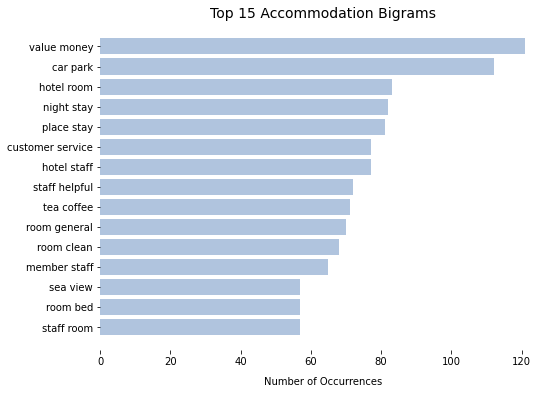

In [53]:
graphmatplot(accom_bigram,"Top 15 Accommodation Bigrams")

In [54]:
# Create dataframe for food
food_bigram = pd.DataFrame(nouns_food["bigrams_count"].sum().most_common(),columns = ["Word","Count"] )
food_bigram["Word"] = food_bigram["Word"].apply(lambda x: ' '.join(x))

In [55]:
food_bigram.head(15)

,Word,Count
0,food service,621
1,service food,362
2,food staff,278
3,staff food,237
4,value money,236
5,quality food,160
6,service staff,146
7,customer service,138
8,ice cream,130
9,portion size,108


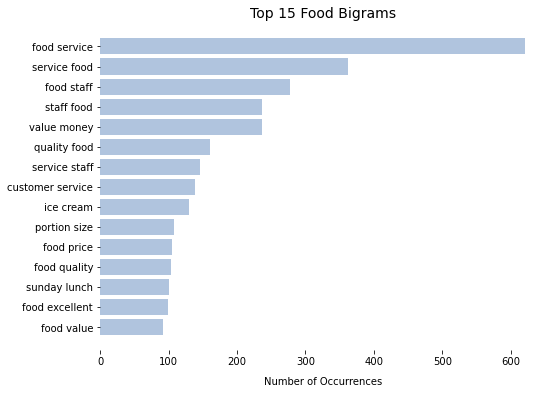

In [56]:
graphmatplot(food_bigram,"Top 15 Food Bigrams")

In [57]:
# Create dataframe for attractions
attract_bigram = pd.DataFrame(nouns_attract["bigrams_count"].sum().most_common(),columns = ["Word","Count"] )
attract_bigram["Word"] = attract_bigram["Word"].apply(lambda x: ' '.join(x))

In [58]:
attract_bigram.head(15)

,Word,Count
0,car park,56
1,value money,36
2,ice cream,32
3,place visit,31
4,gift shop,29
5,gold ticket,26
6,tulip festival,26
7,play area,21
8,visit garden,18
9,boat trip,18


In [59]:
# Replace repeated words
#attract_bigram = attract_bigram.replace(to_replace ="gotham park",value ="hotham park")
attract_bigram = attract_bigram.replace(to_replace ="beach beach",value ="beach experience")

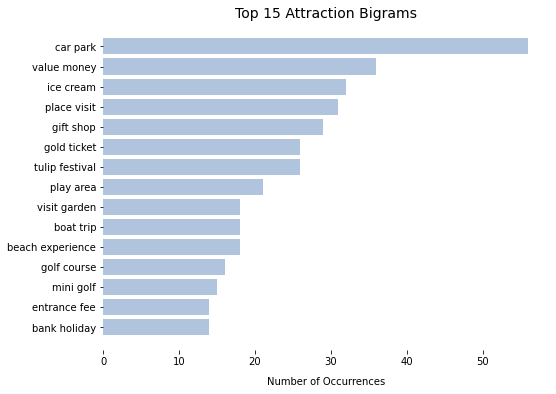

In [60]:
graphmatplot(attract_bigram,"Top 15 Attraction Bigrams")

# Section 7: Exploding dataframe on noun-phrases and nouns

In [61]:
df.head(2)

,OrigInd,Category,Town,Rating,all_text,sentences,len,cleaned_sentences,noun_phrases
0,0,Accommodation,Bognor,4,"Nice break, shame about the accommodation... W...","Nice break, shame about the accommodation... W...",173,nice break shame accommodation booked night st...,"[shame accommodation, night stay december post..."
0,0,Accommodation,Bognor,4,"Nice break, shame about the accommodation... W...",We’d never been to Butlins before so weren’t r...,283,would never not really sure expect review eith...,"[good terrible, usual choice]"


In [62]:
# Split each noun phrase onto a separate line and check shape
df3 = df.explode("noun_phrases")
df3.shape

(80298, 9)

In [63]:
df3.head(2)

,OrigInd,Category,Town,Rating,all_text,sentences,len,cleaned_sentences,noun_phrases
0,0,Accommodation,Bognor,4,"Nice break, shame about the accommodation... W...","Nice break, shame about the accommodation... W...",173,nice break shame accommodation booked night st...,shame accommodation
0,0,Accommodation,Bognor,4,"Nice break, shame about the accommodation... W...","Nice break, shame about the accommodation... W...",173,nice break shame accommodation booked night st...,night stay december post-christmas


In [64]:
df3["noun_phrases"].iloc[0]

'shame accommodation'

In [65]:
# Uncomment to save over the file
df3.to_csv("noun_phrase_exploded.csv")

# Section 8: Summary

Comments:

* Keyword extraction identified key words in the reviews which helps to identify some of the main aspects in the reviews
* Bigrams give more perspective by linking words like 'car' and 'park' together
* There is quite a lot of repetition amongst the bigrams for the food category in particular, with the word 'food' being teamed up with many other different words, in particular the word 'service'. This suggests the topics might be fuzzy.
* Unigrams and Bigrams are a bit too specific, more useful would be topics based on the distribution of topics such as that provided by topic modelling which is considered in the Notebook - Topic Models
* Splitting out the noun-phrases and exploding them onto separate lines gives a dataframe of almost 80,000 lines on which to generate sentiment. Also, these phrases need to be clustered into summary topics, e.g. 'the fish and chips were nice' to a topic of 'food'.
